# Assignment 2 -- Text classification

by Kolokathi Fotini (DS3516007)   and   Spartalis Iosif (DS3516018)

In [125]:
import os
import re
import nltk
import string
import time
import random
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt

 
class LemmaTokenizer(object):
    """custom tokenizer with lemmatizer to be used in sklearn countVectorizer"""
    def __init__(self):
        self.tkzer = RegexpTokenizer(r'\b[^\d\W]+\b') #This tokenizer removes punctuation and numbers
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        filtered_lemm = []
        for w in self.tkzer.tokenize(doc):
            noun = self.wnl.lemmatize(w, pos='n')
            verb = self.wnl.lemmatize(w, pos='v')
            if(noun!=w):
                filtered_lemm.append(noun)
            else:
                filtered_lemm.append(verb)
            
        return filtered_lemm 

    
    
def load_data(train_dir,start,end):
    '''
    input: a string which contains the path of  data and a 'start'  and an 'end' number of the folder name
    i.e if we want to open from part1 to part9 folders then start=1 and end=10
    output: one list in which each element is a text/email and another list in which each element is the target name of the 
    corresponding text(in our case 'spam' or 'ham')'''

    #keep path of files of training data
    emails_path = [os.path.join(train_dir+ str(i),f) for i in range(start,end) for f in os.listdir(train_dir + str(i))] 
    emails = []
    targets = []
    i=0
    for email_path in emails_path:
        with open(email_path,encoding='utf-8') as f:
            emails.append(f.readlines()[1:][1]) # we do not take the first line of each emails which is the subject
            file_name = emails_path[i].split("\\")[3]
            if(file_name[0:5]=="spmsg"):
                targets.append('spam')
            else:
                targets.append('ham')    
        i+=1
    return emails,targets




def tf_idf(tfs):
    '''
    unput : 
        tfs: doc-term numpy array in which each element contains the corresponding tf(t,d)
    output:
        a tf-idf numpy array with normalized term vectors
    '''
    idf_list = []
    # total number of docs
    N = tfs.shape[0] 
    # total number of terms
    terms = tfs.shape[1] 
    '''Here we calculate the idf for each term of doc-term matrix and append each of it in a list'''
    for i in range (0,terms):
        '''
        see: 
        http://stackoverflow.com/questions/36966019/how-aretf-idf-calculated-by-the-scikit-learn-tfidfvectorizer
        http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer    
        http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

        idf(d, t) = log [ (1 + N) / (1 + df(d, t)) ] + 1.
        '''
        idf_list.append((np.log((N+1)/(np.count_nonzero(tfs[:,i])+1))+1))

    '''Here we create a numpy array in which we have concatenated the idf_list N times'''
    idf_array = np.array(idf_list) # convert idf_list to numpy array
    idfs = np.tile(idf_array,(N,1))
    ''' tf-idf(d, t) = tf(d,t) * idf(d, t)'''
    tf_idf = tfs*idfs
    ''' Normalize term vectors of tf_idf array with l2 norm'''
    # see: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html#sklearn.preprocessing.normalize
    tf_idf_normalized = normalize(tf_idf,axis=0)
    return tf_idf_normalized



def select_features_pca(train_X, test_X, k=1000):
    '''
    input:
        train_X: tf-idf array of training data
        test_X: tf-idf array of test data
        k: number of most important principal components we will keep after dimentionality reduction
    output:
        train_X and test_X transformed numpy arrays
    '''
    selector = PCA(n_components=k)
    selector.fit(train_X)
    train_X = selector.transform(train_X)
    test_X = selector.transform(test_X)
    return train_X, test_X



def select_features_svd(train_X, test_X, k=1000):
    '''
    In practice TruncatedSVD is useful on large sparse datasets which cannot be centered without making the memory usage 
    explode.
    see:
    http://scikit-learn.org/stable/modules/decomposition.html
    http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

    input:
        train_X: tf-idf array of training data
        test_X: tf-idf array of test data
        k: number of most important principal components we will keep after dimentionality reduction
    output:
        train_X and test_X transformed numpy arrays
    '''
    selector = TruncatedSVD(n_components=k)
    selector.fit(train_X)
    train_X = selector.transform(train_X)
    test_X = selector.transform(test_X)
    return train_X, test_X


    
def report(test_targets,y_pred):
    '''
    input:
       test_targets: list with the test targets 
       y_pred: list with the predicted test targets
    '''
    #prints classification report and confusion matrix'''
    target_names = ['ham','spam']
    print('Accuracy: %s' % metrics.accuracy_score(test_targets,y_pred))
    print()
    '''Classification report'''
    print('------------------------Classification report------------------------')
    print()
    print(classification_report(test_targets, y_pred, target_names=target_names))
    print('---------------------------------------------------------------------')
    print('Confusion matrix:')
    print(metrics.confusion_matrix(test_targets,y_pred))
    
    

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10), scoring='f1_macro'): # f1 is only for binary targets,so we use f1_macro
    '''                                                                                      
    Define learning curves plot function
    ''' 
    '''
    estimator : object type that implements the "fit" and "predict" methods
            An object of that type which is cloned for each validation.

    title : string.Title for the chart.

    X: a tf-idf numpy array with normalized term vectors

    y: a list with the train targets

    ylim: tuple, defines minimum and maximum yvalues plotted.

    cv: Determines the cross-validation splitting strategy. 
        Possible inputs for cv are:
                - None, to use the default 3-fold cross-validation,
                -integer, to specify the number of folds.
                - An object to be used as a cross-validation generator.
                - An iterable yielding train/test splits.
     n_jobs : integer, optional
            Number of jobs to run in parallel (default 1).

    train sizes: proportions of size of training size

    scoring: name of metric .See also: http://scikit-learn.org/stable/modules/model_evaluation.html
    '''
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1 macro score")
    # http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, 
        scoring= scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


## Load and preprocessing data

In [86]:
train_dir =".\\bare\\part"

'''load data'''
emails,targets = load_data(train_dir,1,11)

'''shuffle data'''
c = list(zip(emails, targets))
random.shuffle(c)
emails, targets = zip(*c)
emails = list(emails)
targets = list(targets)

'''split targets for training and test data'''
train_targets = targets[:int((len(targets)+1)*.80)] # 80% to training set
test_targets = targets[int(len(targets) * .80+1):] # 20% to test data


In [87]:

'''prepocessing of data'''
data= emails


* ##  Tf-idf 

In [88]:
'''document-term matrix with Tfs'''
vectorizer = CountVectorizer(min_df=1,tokenizer=LemmaTokenizer(), stop_words = 'english')
tfs = vectorizer.fit_transform(data)
tfs = tfs.toarray() # convert matrix to numpy array

'''tf-idf document-term numpy array'''
tf_idf_ = tf_idf(tfs)

In [89]:
tf_idf_.shape

(2893, 46900)

In [90]:
# Dimentionality reduction

'''SVD to train and test tf-idf arrays'''
train_data_svd,test_data_svd = select_features_svd(tf_idf_[:int((tf_idf_.shape[0]+1)*.80)],tf_idf_[int(tf_idf_.shape[0]*.80+1):])

### Execute Classification

* #### Baselines classifiers

1) Here we will use a classifier that always predicts the **most frequent** label in the training set.

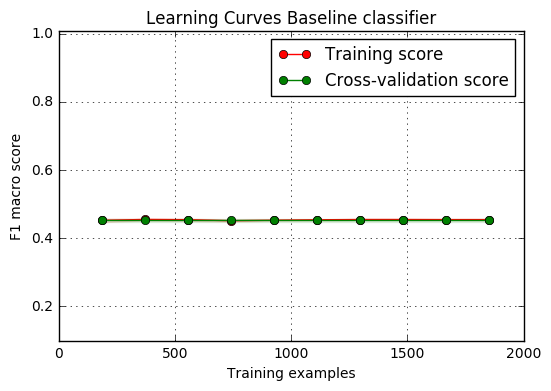

In [143]:
### THA FYGEI..EINAI GIA BASELINES GIA NA KATALAVOUME TH SHMASIA TOUS

from sklearn.dummy import DummyClassifier

'''load a dummy classifier to make predictions based on the most_frequent class value'''
dummy_classifier_1 = DummyClassifier(strategy="most_frequent")

'''plot learning curve'''
title = "Learning Curves Baseline classifier" 
'''
The ShuffleSplit iterator will generate a user defined number of independent train / test dataset splits. 
Samples are first shuffled and then split into a pair of train and test sets.
Random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.
It is possible to control the randomness for reproducibility of the results by explicitly seeding the random_state pseudo random number generator.

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html
'''
#n_splits: Number of re-shuffling & splitting iterations.
#random_state: Pseudo-random number generator state used for random sampling.
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
plot_learning_curve(dummy_classifier_1, title, train_data_svd,train_targets, (0.1, 1.01), cv=cv, n_jobs=-1)
plt.show()


In [144]:
'''Train classifier'''
gs_clf = dummy_classifier_1.fit(train_data_svd,train_targets)

'''make prediction'''
Y_pred_most_freq = gs_clf.predict(test_data_svd)


'''Classification report''' 
report(test_targets,Y_pred_most_freq)


#    confusion matrix

#        PREDICTED
#      ham      spam
#    -------------------
#    |        |        |
#ham |   TN   |  FP    |
#    |--------|--------|
#spam|   FN   |  TP    |
#    |        |        |
#    -------------------



# aytos o classifier fainetai na einai isaxios to naive.Ara o naive den exei ekpaideutei polu swsta.

Accuracy: 0.835640138408

------------------------Classification report------------------------

             precision    recall  f1-score   support

        ham       0.84      1.00      0.91       483
       spam       0.00      0.00      0.00        95

avg / total       0.70      0.84      0.76       578

---------------------------------------------------------------------
Confusion matrix:
[[483   0]
 [ 95   0]]


C:\Users\fotin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [145]:
#sum(target=='ham' for target in test_targets)

2) Now we will use a basile classifier that generates predictions uniformly at random.

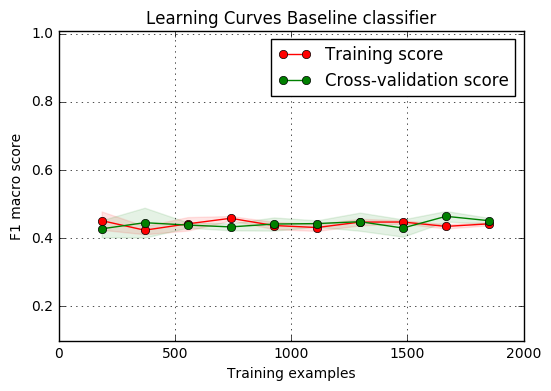

In [146]:
'''load a dummy classifier that generates predictions uniformly at random'''
dummy_classifier_2 = DummyClassifier(strategy="uniform")

'''plot learning curve'''
title = "Learning Curves Baseline classifier" 
'''
The ShuffleSplit iterator will generate a user defined number of independent train / test dataset splits. 
Samples are first shuffled and then split into a pair of train and test sets.
Random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.
It is possible to control the randomness for reproducibility of the results by explicitly seeding the random_state pseudo random number generator.

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html
'''
#n_splits: Number of re-shuffling & splitting iterations.
#random_state: Pseudo-random number generator state used for random sampling.
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
plot_learning_curve(dummy_classifier_2, title, train_data_svd,train_targets, (0.1, 1.01), cv=cv, n_jobs=-1)
plt.show()

In [147]:
'''Train classifier'''
gs_clf = dummy_classifier_2.fit(train_data_svd,train_targets)

'''make prediction'''
Y_pred_ = gs_clf.predict(test_data_svd)

'''Classification report''' 
report(test_targets,Y_pred_)

#    confusion matrix

#        PREDICTED
#      ham      spam
#    -------------------
#    |        |        |
#ham |   TN   |  FP    |
#    |--------|--------|
#spam|   FN   |  TP    |
#    |        |        |
#    -------------------


Accuracy: 0.51384083045

------------------------Classification report------------------------

             precision    recall  f1-score   support

        ham       0.85      0.51      0.64       483
       spam       0.18      0.54      0.27        95

avg / total       0.74      0.51      0.58       578

---------------------------------------------------------------------
Confusion matrix:
[[246 237]
 [ 44  51]]


In [148]:
#sum(target1==target2=='spam' for target1,target2 in zip(Y_pred_,test_targets))

* #### Logistic Regression

In [149]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

start_time = time.time()

# Here C=1/lambda.So larger C ==> weaker regularization(If we want to prevent underfitting)
# Smallar C ==> stronger regularization (If we want to prevent overfitting)
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'fit_intercept':[True,False],'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag'],
             'tol':[1e-2,1e-3,1e-4,1e-5]}

'''cross validation'''
# Hyperparameter cv=3  by default, so we make 3-fold cross validation.If we set cv=10 it takes more time to run
gs_clf = GridSearchCV(LogisticRegression(), param_grid,n_jobs=-1)


gs_clf = gs_clf.fit(train_data_svd,train_targets)

elapsed_time = time.time() - start_time
print(elapsed_time)

125.76423835754395


In [150]:
'''Estimator values.It has default parameters that we did not specify'''
gs_clf.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.01,
          verbose=0, warm_start=False)

In [151]:
'''Get the best parameter values directrly'''
gs_clf.best_params_

{'C': 10, 'fit_intercept': False, 'solver': 'newton-cg', 'tol': 0.01}

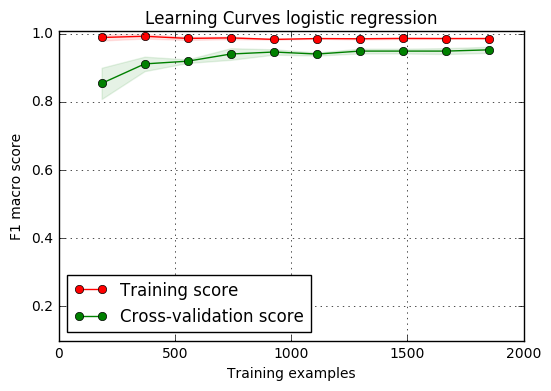

In [152]:
''' Load classifier with best params'''
LR = LogisticRegression(C=gs_clf.best_params_['C'],fit_intercept=gs_clf.best_params_['fit_intercept'],
                        solver=gs_clf.best_params_['solver'],tol=gs_clf.best_params_['tol'])

'''plot learning curve'''
title = "Learning Curves logistic regression" 
'''
The ShuffleSplit iterator will generate a user defined number of independent train / test dataset splits. 
Samples are first shuffled and then split into a pair of train and test sets.
Random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.
It is possible to control the randomness for reproducibility of the results by explicitly seeding the random_state pseudo random number generator.

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html
'''
#n_splits: Number of re-shuffling & splitting iterations.
#random_state: Pseudo-random number generator state used for random sampling.
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
plot_learning_curve(LR, title, train_data_svd,train_targets, (0.1, 1.01), cv=cv, n_jobs=-1)
plt.show()

In [153]:
'''Using the best parameters to make predictions with logistic regression'''

'''Train classifier''' 
regr_clf = LR.fit(train_data_svd,train_targets)

'''make prediction'''
Y_pred_regr = regr_clf.predict(test_data_svd)

'''Classification report''' 
report(test_targets,Y_pred_regr)

#    confusion matrix

#        PREDICTED
#      ham      spam
#    -------------------
#    |        |        |
#ham |   TN   |  FP    |
#    |--------|--------|
#spam|   FN   |  TP    |
#    |        |        |
#    -------------------



Accuracy: 0.984429065744

------------------------Classification report------------------------

             precision    recall  f1-score   support

        ham       0.98      1.00      0.99       483
       spam       1.00      0.91      0.95        95

avg / total       0.98      0.98      0.98       578

---------------------------------------------------------------------
Confusion matrix:
[[483   0]
 [  9  86]]


* #### KNN

In [154]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics


start_time = time.time()

# define the parameter values that should be searched
k_range = list(range(1, 31))

# Another parameter besides k that we might vary is the weights parameters
# uniform (all points in the neighborhood are weighted equally)
# distance (weights closer neighbors more heavily than further neighbors)

param_grid = {'n_neighbors':k_range,'weights':['uniform','distance'],'algorithm':['auto','ball_tree','kd_tree','brute'],
             'metric':['euclidean','cityblock','minkowski'],'p':[1,2]}

'''cross validation'''
gs_clf = RandomizedSearchCV(KNeighborsClassifier(),param_grid,n_jobs=-1)

'''train classifier'''
gs_clf = gs_clf.fit(train_data_svd,train_targets)

elapsed_time = time.time() - start_time
print(elapsed_time)

18.929537296295166


In [155]:
'''Estimator values.It has default parameters that we did not specify'''
gs_clf.best_estimator_

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=10, p=1,
           weights='uniform')

In [156]:
'''Get the best parameter values directrly'''
gs_clf.best_params_

{'algorithm': 'kd_tree',
 'metric': 'euclidean',
 'n_neighbors': 10,
 'p': 1,
 'weights': 'uniform'}

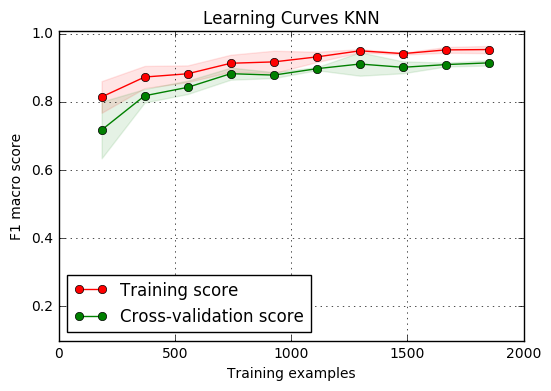

In [157]:
''' Load classifier with best parameters'''
KNN = KNeighborsClassifier(n_neighbors=gs_clf.best_params_['n_neighbors'],weights=gs_clf.best_params_['weights'],algorithm=gs_clf.best_params_['algorithm'],
                           metric=gs_clf.best_params_['metric'],p=gs_clf.best_params_['p'])

'''plot learning curve'''
title = "Learning Curves KNN" 
'''
The ShuffleSplit iterator will generate a user defined number of independent train / test dataset splits. 
Samples are first shuffled and then split into a pair of train and test sets.
Random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.
It is possible to control the randomness for reproducibility of the results by explicitly seeding the random_state pseudo random number generator.

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html
'''
#n_splits: Number of re-shuffling & splitting iterations.
#random_state: Pseudo-random number generator state used for random sampling.
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
plot_learning_curve(KNN, title, train_data_svd,train_targets, (0.1, 1.01), cv=cv, n_jobs=-1)
plt.show()


In [158]:
'''Using the best parameters to make predictions with KNN'''

'''Train classifier''' 
knn_clf = KNN.fit(train_data_svd,train_targets)

'''make prediction'''
Y_pred_knn = knn_clf.predict(test_data_svd)

'''Classification report''' 
report(test_targets,Y_pred_knn)
#    confusion matrix

#        PREDICTED
#      ham      spam
#    -------------------
#    |        |        |
#ham |   TN   |  FP    |
#    |--------|--------|
#spam|   FN   |  TP    |
#    |        |        |
#    -------------------


Accuracy: 0.975778546713

------------------------Classification report------------------------

             precision    recall  f1-score   support

        ham       0.99      0.98      0.99       483
       spam       0.90      0.96      0.93        95

avg / total       0.98      0.98      0.98       578

---------------------------------------------------------------------
Confusion matrix:
[[473  10]
 [  4  91]]


* #### SVM

In [159]:
from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.svm import SVC
import scipy.stats
from sklearn import metrics
from sklearn.metrics import classification_report

start_time = time.time()

# For hyperparameter C see:
# https://stats.stackexchange.com/questions/31066/what-is-the-influence-of-c-in-svms-with-linear-kernel

param_grid = {'C': scipy.stats.expon(scale=100),
              'gamma': scipy.stats.expon(scale=.1), 'kernel':['linear','poly','rbf','sigmoid']}

'''cross validation'''
gs_clf = RandomizedSearchCV(SVC(), param_grid,n_jobs=-1)

'''train classifier'''
gs_clf = gs_clf.fit(train_data_svd,train_targets)

elapsed_time = time.time() - start_time
print(elapsed_time)


20.19280433654785


In [160]:
'''Estimator values.It has default parameters that we did not specify'''
gs_clf.best_estimator_

SVC(C=51.106838263095852, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0244464172714456,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [161]:
'''Get the best parameter values directrly'''
gs_clf.best_params_

{'C': 51.106838263095852, 'gamma': 0.0244464172714456, 'kernel': 'rbf'}

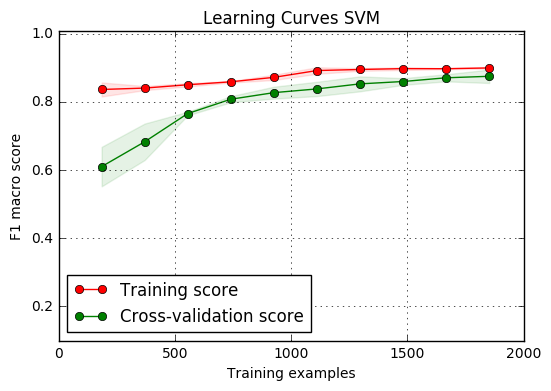

In [162]:
''' Load classifier '''
SVM = SVC(C=gs_clf.best_params_['C'],gamma=gs_clf.best_params_['gamma'],kernel=gs_clf.best_params_['kernel'])

'''plot learning curve'''
title = "Learning Curves SVM" 
'''
The ShuffleSplit iterator will generate a user defined number of independent train / test dataset splits. 
Samples are first shuffled and then split into a pair of train and test sets.
Random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.
It is possible to control the randomness for reproducibility of the results by explicitly seeding the random_state pseudo random number generator.

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html
'''
#n_splits: Number of re-shuffling & splitting iterations.
#random_state: Pseudo-random number generator state used for random sampling.
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
plot_learning_curve(SVM, title, train_data_svd,train_targets, (0.1, 1.01), cv=cv, n_jobs=-1)
plt.show()


In [163]:
'''Using the best parameters to make predictions with SVM'''

'''Train classifier''' 
svm_clf = SVM.fit(train_data_svd,train_targets)

'''make prediction'''
Y_pred_svm = svm_clf.predict(test_data_svd)

'''Classification report''' 
report(test_targets,Y_pred_svm)

#    confusion matrix

#        PREDICTED
#      ham      spam
#    -------------------
#    |        |        |
#ham |   TN   |  FP    |
#    |--------|--------|
#spam|   FN   |  TP    |
#    |        |        |
#    -------------------


Accuracy: 0.930795847751

------------------------Classification report------------------------

             precision    recall  f1-score   support

        ham       0.93      1.00      0.96       483
       spam       0.98      0.59      0.74        95

avg / total       0.93      0.93      0.92       578

---------------------------------------------------------------------
Confusion matrix:
[[482   1]
 [ 39  56]]


* #### Naive Bayes

In [164]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report

# For MultinomialNB you can see: http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html


'''
There are 3 versions of naive bayes algorithm as we can see from here: http://scikit-learn.org/stable/modules/naive_bayes.html

1.GaussianNB which is not a good fit for document classification.
2.BernoulliNB which is good for document classification but it accepts inly boolean features.
3.MultinomialNB is good for document classification.It is suitable for classification with discrete features (e.g., word counts 
for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, 
fractional counts such as tf-idf also work well.

As SVD may return negative elements, we cannot use MultinomialNB.So we will take tf-idf numpy array without making dimentionality
reduction.Of course we do not wait as good results as the previous algorithms gave.
'''



param_grid = {'fit_prior':[True,False]}
'''cross validation'''
gs_clf = GridSearchCV(MultinomialNB(), param_grid)

'''train classifier'''
gs_clf = gs_clf.fit(tf_idf_[:int((tf_idf_.shape[0]+1)*.80)],train_targets)


In [165]:
'''Estimator values.It has default parameters that we did not specify'''
gs_clf.best_estimator_

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [166]:
'''Get the best parameter values directrly'''
gs_clf.best_params_

{'fit_prior': True}

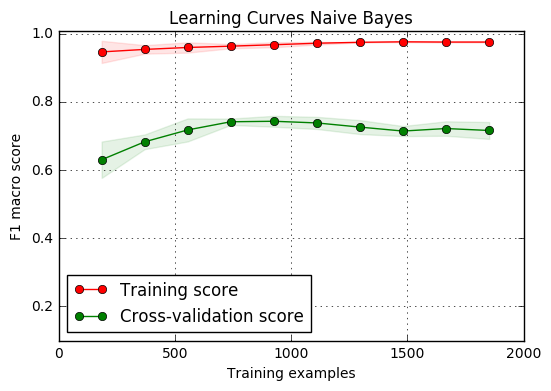

In [167]:
''' Load classifier '''
NaiveBayes = MultinomialNB(fit_prior=gs_clf.best_params_['fit_prior'])

'''plot learning curve'''
title = "Learning Curves Naive Bayes" 
'''
The ShuffleSplit iterator will generate a user defined number of independent train / test dataset splits. 
Samples are first shuffled and then split into a pair of train and test sets.
Random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.
It is possible to control the randomness for reproducibility of the results by explicitly seeding the random_state pseudo random number generator.

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html
'''
#n_splits: Number of re-shuffling & splitting iterations.
#random_state: Pseudo-random number generator state used for random sampling.
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
plot_learning_curve(NaiveBayes, title, tf_idf_[:int((tf_idf_.shape[0]+1)*.80)],train_targets, (0.1, 1.01), cv=cv, n_jobs=-1)
plt.show()


In [168]:
'''Using the best parameters to make predictions with Naive Bayes'''

'''Train classifier''' 
nb_clf = NaiveBayes.fit(tf_idf_[:int((tf_idf_.shape[0]+1)*.80)],train_targets)

'''make prediction'''
Y_pred_nb = nb_clf.predict(tf_idf_[int(tf_idf_.shape[0]*.80+1):])

'''Classification report''' 
report(test_targets,Y_pred_nb)

#    confusion matrix

#        PREDICTED
#      ham      spam
#    -------------------
#    |        |        |
#ham |   TN   |  FP    |
#    |--------|--------|
#spam|   FN   |  TP    |
#    |        |        |
#    -------------------


Accuracy: 0.776816608997

------------------------Classification report------------------------

             precision    recall  f1-score   support

        ham       0.96      0.77      0.85       483
       spam       0.41      0.83      0.55        95

avg / total       0.87      0.78      0.80       578

---------------------------------------------------------------------
Confusion matrix:
[[370 113]
 [ 16  79]]


* ## Word Embeddings

In [169]:
from nltk.tokenize import word_tokenize

'''
output:
    model: a dictionary which has as key the word and as value the numpy array with one row the corresponding vector
'''
def load_embeddings(gloveFile):
    f = open(gloveFile,'r',encoding='utf8')
    model = {}
    for line in f:
        word = line.split(' ')[0]
        model[word] = np.array(line.split(' ')[1:],dtype='f')
    return model


In [170]:
embeddings = load_embeddings('glove.6B.300d.txt')

In [171]:
'''

#ARGEI POLY...............
start_time = time.time()

# data: processed data
T = np.zeros((len(data),300))

for doc_id, text in enumerate(data):
    word_sequences=word_tokenize(text)
    c =0 
    for word in word_sequences:
        if word in list(embeddings):
            c+=1
            T[doc_id,:]+=embeddings[word]
    if(c>0):
        T[doc_id,:] = T[doc_id,:]/c
            
       
elapsed_time = time.time() - start_time
print(elapsed_time)


'''

'\n\n#ARGEI POLY...............\nstart_time = time.time()\n\n# data: processed data\nT = np.zeros((len(data),300))\n\nfor doc_id, text in enumerate(data):\n    word_sequences=word_tokenize(text)\n    c =0 \n    for word in word_sequences:\n        if word in list(embeddings):\n            c+=1\n            T[doc_id,:]+=embeddings[word]\n    if(c>0):\n        T[doc_id,:] = T[doc_id,:]/c\n            \n       \nelapsed_time = time.time() - start_time\nprint(elapsed_time)\n\n\n'